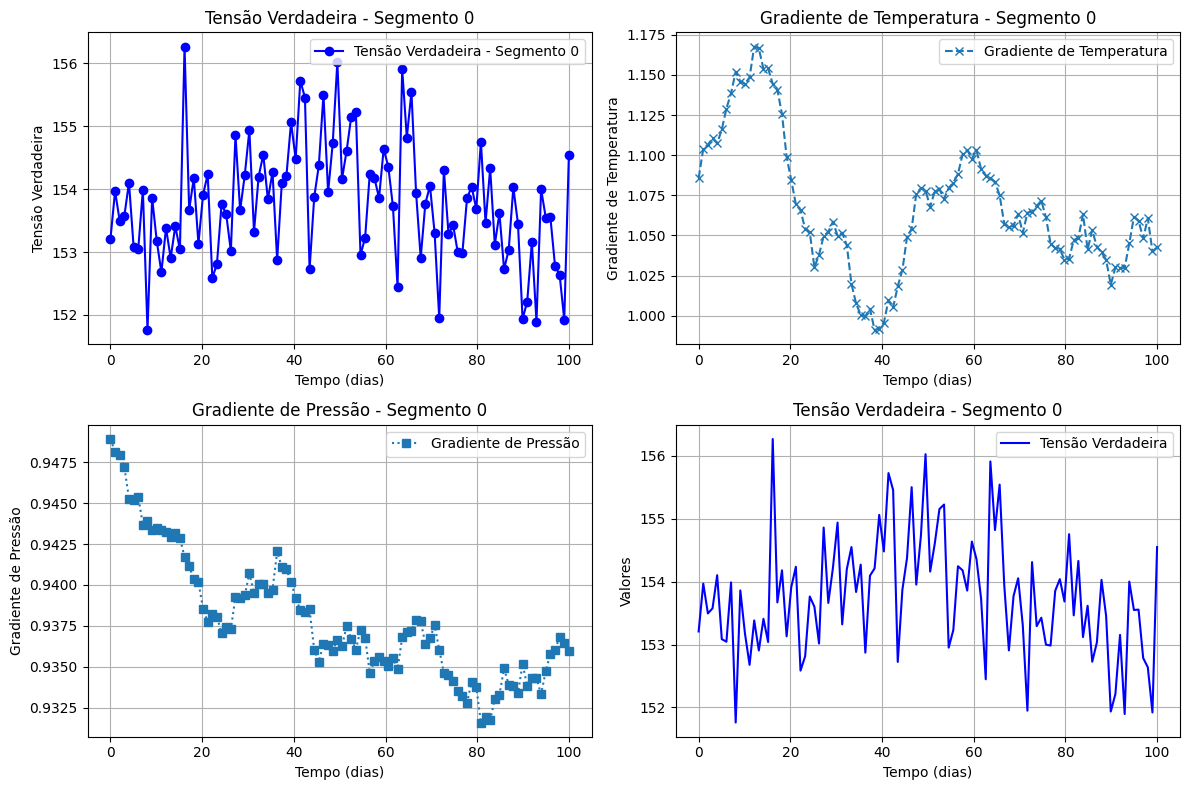

Relatório do Segmento 0:

Média da Tensão Verdadeira: 153.77040584028217
Desvio Padrão da Tensão Verdadeira: 0.9335811098854107
Valor Mínimo da Tensão Verdadeira: 151.7601210558372
Valor Máximo da Tensão Verdadeira: 156.26627086232088
Mediana da Tensão Verdadeira: 153.76626336170466
Percentil 25 da Tensão Verdadeira: 153.11038594266603
Percentil 75 da Tensão Verdadeira: 154.25080369057184
Amplitude da Tensão Verdadeira: 4.506149806483677
Tempo do Valor Máximo da Tensão: 16 dias
Taxa Máxima de Variação da Tensão: 3.4617825976640404 por dia
Tempo da Taxa Máxima de Variação: 62 dias


In [82]:
class Parametros:
    def __init__(self, num_segmentos, tensao_medida, coef_erro, desvio_ruido, forca, kt, kp, kf, dia_interno, dia_externo):
        if self.validar_parametros(num_segmentos, tensao_medida):
            self.set_parametros(num_segmentos, tensao_medida, coef_erro, desvio_ruido, forca, kt, kp, kf, dia_interno, dia_externo)
        else:
            raise ValueError("Parâmetros inválidos. Certifique-se de que num_segmentos seja maior que zero e tensao_medida seja positiva.")

    def validar_parametros(self, num_segmentos, tensao_medida):
        return num_segmentos > 0 and tensao_medida > 0

    def set_parametros(self, num_segmentos, tensao_medida, coef_erro, desvio_ruido, forca, kt, kp, kf, dia_interno, dia_externo):
        self.num_segmentos = num_segmentos
        self.tensao_medida = tensao_medida
        self.coef_erro = coef_erro
        self.desvio_ruido = desvio_ruido
        self.forca = forca
        self.kt = kt
        self.kp = kp
        self.kf = kf
        self.dia_interno = dia_interno
        self.dia_externo = dia_externo

def calcular_tensao_verdadeira(tensao, parametros, grad_temp, grad_pressao):
    # Erro gaussiano com dependência temporal
    erro_temporal = np.random.normal(0, parametros.coef_erro * tensao, len(grad_temp))
    erro = erro_temporal + parametros.coef_erro * np.random.normal(0, tensao, len(grad_temp))

    # Modelagem mais complexa de compensação de temperatura e pressão
    temp_comp = parametros.kt * np.convolve(grad_temp, grad_temp, 'same') * tensao
    pressao_comp = parametros.kp * np.convolve(grad_pressao, grad_pressao, 'same') * tensao

    # Componente de força não-linear
    forca_comp = parametros.kf * parametros.forca * (1 + np.sin(grad_temp))

    # Ruído não-linear
    ruido = np.random.normal(0, parametros.desvio_ruido, len(grad_temp)) + 0.01 * np.sin(0.1 * grad_temp)

    # Tensão verdadeira resultante
    tensao_verdadeira = tensao - erro + temp_comp + pressao_comp + forca_comp + ruido
    return tensao_verdadeira

def criar_gradientes(num_segmentos, dias):
    gradientes_temp = []
    gradientes_pressao = []

    for i in range(num_segmentos):
        tempo = np.linspace(0, dias, dias)
        
        # Simulando gradientes de temperatura
        grad_temp = np.zeros(dias)
        grad_temp[0] = np.random.uniform(0.9, 1.1)  # Valor inicial
        for t in range(1, dias):
            grad_temp[t] = grad_temp[t - 1] + np.random.normal(0, 0.01)  # Pequenas variações ao longo do tempo

        # Simulando gradientes de pressão
        grad_pressao = np.zeros(dias)
        grad_pressao[0] = np.random.uniform(0.9, 1.1)  # Valor inicial
        for t in range(1, dias):
            grad_pressao[t] = grad_pressao[t - 1] + np.random.normal(0, 0.001)  # Pequenas variações ao longo do tempo

        gradientes_temp.append(grad_temp)
        gradientes_pressao.append(grad_pressao)

    return gradientes_temp, gradientes_pressao

from scipy.optimize import curve_fit

# Função não linear para ajuste
def funcao_nao_linear(tempo, a, b, c):
    return a * np.sin(b * tempo) + c

def criar_riser_avancado(parametros, gradientes_temp, gradientes_pressao):
    tensao_cabeca = []

    for grad_temp, grad_pressao in zip(gradientes_temp, gradientes_pressao):
        # Ajuste uma função não linear aos gradientes
        popt, _ = curve_fit(funcao_nao_linear, tempo, grad_temp)
        a, b, c = popt

        # Use os parâmetros ajustados para calcular a tensão verdadeira
        tensao_verdadeira = calcular_tensao_verdadeira(parametros.tensao_medida, parametros, a * grad_temp, grad_pressao)
        tensao_cabeca.append(tensao_verdadeira)

    return tensao_cabeca

def criar_visualizacoes_tempo(tensao_cabeca, gradientes_temp, gradientes_pressao, dias, segmento_selecionado, exibir_grad_temp=True, exibir_grad_pressao=True):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    tempo_dias = np.linspace(0, dias, dias)

    axs[0, 0].plot(tempo_dias, tensao_cabeca[segmento_selecionado], label=f'Tensão Verdadeira - Segmento {segmento_selecionado}', color='blue', linestyle='-', marker='o')
    axs[0, 0].set_title(f"Tensão Verdadeira - Segmento {segmento_selecionado}")

    axs[0, 0].set_xlabel("Tempo (dias)")
    axs[0, 0].set_ylabel("Tensão Verdadeira")
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    if exibir_grad_temp:
        axs[0, 1].plot(tempo_dias, gradientes_temp[segmento_selecionado], label=f'Gradiente de Temperatura', linestyle='--', marker='x')
        axs[0, 1].set_title(f"Gradiente de Temperatura - Segmento {segmento_selecionado}")
        axs[0, 1].set_xlabel("Tempo (dias)")
        axs[0, 1].set_ylabel("Gradiente de Temperatura")
        axs[0, 1].grid(True)
        axs[0, 1].legend()

    if exibir_grad_pressao:
        axs[1, 0].plot(tempo_dias, gradientes_pressao[segmento_selecionado], label=f'Gradiente de Pressão', linestyle=':', marker='s')
        axs[1, 0].set_title(f"Gradiente de Pressão - Segmento {segmento_selecionado}")
        axs[1, 0].set_xlabel("Tempo (dias)")
        axs[1, 0].set_ylabel("Gradiente de Pressão")
        axs[1, 0].grid(True)
        axs[1, 0].legend()

    axs[1, 1].plot(tempo_dias, tensao_cabeca[segmento_selecionado], label=f'Tensão Verdadeira', color='blue', linestyle='-')
    axs[1, 1].set_title(f"Tensão Verdadeira - Segmento {segmento_selecionado}")
    axs[1, 1].set_xlabel("Tempo (dias)")
    axs[1, 1].set_ylabel("Valores")
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

def gerar_relatorio_completo(tensao_cabeca, segmento_selecionado):
    segmento = tensao_cabeca[segmento_selecionado]
    tempo = np.arange(len(segmento))

    media_tensao = np.mean(segmento)
    desvio_padrao_tensao = np.std(segmento)
    valor_minimo_tensao = np.min(segmento)
    valor_maximo_tensao = np.max(segmento)
    mediana_tensao = np.median(segmento)
    percentil_25 = np.percentile(segmento, 25)
    percentil_75 = np.percentile(segmento, 75)
    amplitude_tensao = valor_maximo_tensao - valor_minimo_tensao

    # Encontre o ponto de tempo onde ocorre o valor máximo da tensão
    tempo_max_tensao = tempo[np.argmax(segmento)]
    
    # Calcule a taxa de variação da tensão
    taxa_variacao = np.diff(segmento) / np.diff(tempo)
    taxa_max_variacao = np.max(taxa_variacao)
    tempo_max_variacao = tempo[np.argmax(taxa_variacao)]

    print(f"Relatório do Segmento {segmento_selecionado}:\n")
    print(f"Média da Tensão Verdadeira: {media_tensao}")
    print(f"Desvio Padrão da Tensão Verdadeira: {desvio_padrao_tensao}")
    print(f"Valor Mínimo da Tensão Verdadeira: {valor_minimo_tensao}")
    print(f"Valor Máximo da Tensão Verdadeira: {valor_maximo_tensao}")
    print(f"Mediana da Tensão Verdadeira: {mediana_tensao}")
    print(f"Percentil 25 da Tensão Verdadeira: {percentil_25}")
    print(f"Percentil 75 da Tensão Verdadeira: {percentil_75}")
    print(f"Amplitude da Tensão Verdadeira: {amplitude_tensao}")
    print(f"Tempo do Valor Máximo da Tensão: {tempo_max_tensao} dias")
    print(f"Taxa Máxima de Variação da Tensão: {taxa_max_variacao} por dia")
    print(f"Tempo da Taxa Máxima de Variação: {tempo_max_variacao} dias")


# Parâmetros ajustados para Média, Desvio Padrão, Valor Mínimo e Valor Máximo personalizados
parametros = Parametros(
    num_segmentos=10, 
    tensao_medida=150.0, 
    coef_erro=0.0, 
    desvio_ruido=1.0, 
    forca=500.0, 
    kt=0.0002, 
    kp=0.00005, 
    kf=0.001, 
    dia_interno=0.35, 
    dia_externo=0.45
)
# Cria gradientes para cada segmento (exemplo)
dias = 100
gradientes_temp, gradientes_pressao = criar_gradientes(parametros.num_segmentos, dias)

# Segmento selecionado (exemplo)
segmento_selecionado = 0

# Cria e plota os dados para o Segmento 1 (exemplo)
tensao_cabeca = criar_riser(parametros, gradientes_temp, gradientes_pressao)
criar_visualizacoes_tempo(tensao_cabeca, gradientes_temp, gradientes_pressao, dias, segmento_selecionado)

# Usando a nova função para gerar um relatório mais detalhado
gerar_relatorio_completo(tensao_cabeca, segmento_selecionado)

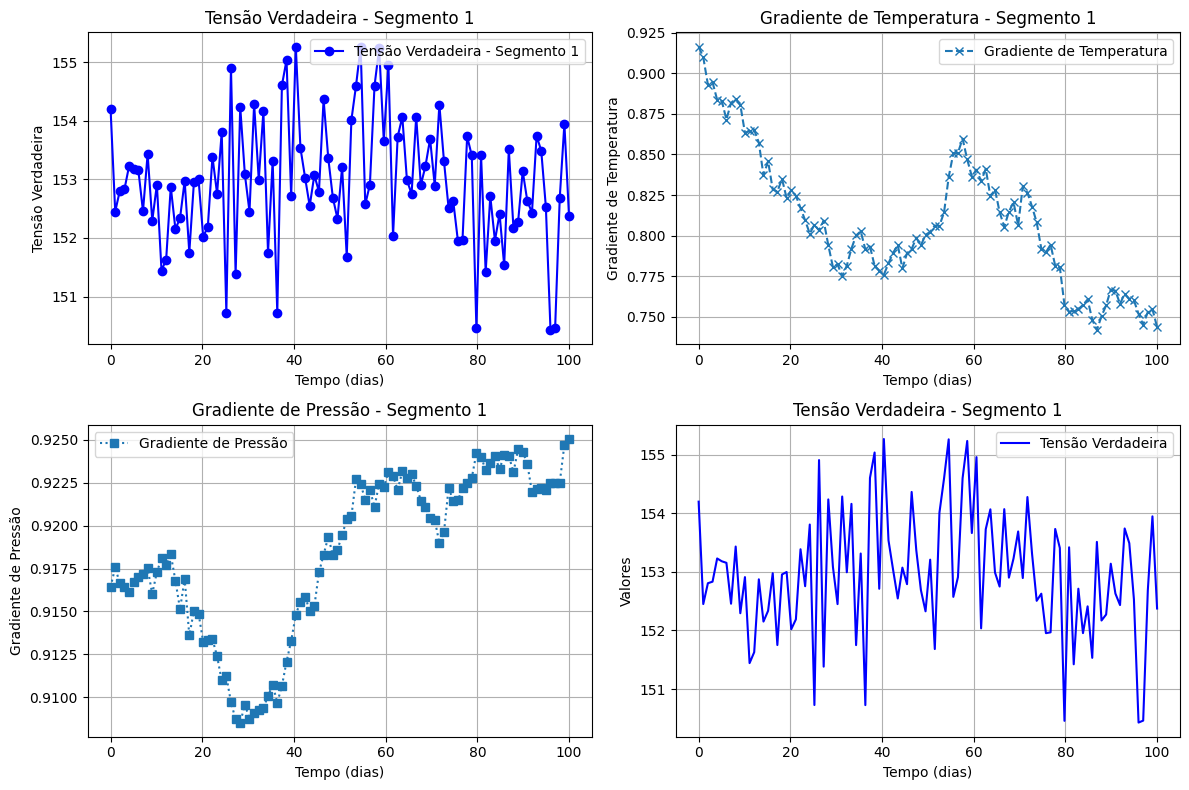

Relatório do Segmento 1:

Média da Tensão Verdadeira: 152.95996118822634
Desvio Padrão da Tensão Verdadeira: 1.0599642177489403
Valor Mínimo da Tensão Verdadeira: 150.42766040402424
Valor Máximo da Tensão Verdadeira: 155.2653825383492
Mediana da Tensão Verdadeira: 152.9090973871003
Percentil 25 da Tensão Verdadeira: 152.36371885042928
Percentil 75 da Tensão Verdadeira: 153.5667339920827
Amplitude da Tensão Verdadeira: 4.837722134324963
Tempo do Valor Máximo da Tensão: 40 dias
Taxa Máxima de Variação da Tensão: 4.179438602423517 por dia
Tempo da Taxa Máxima de Variação: 25 dias


In [83]:
# Segmento selecionado (exemplo)
segmento_selecionado = 1

# Cria e plota os dados para o Segmento 1 (exemplo)
tensao_cabeca = criar_riser(parametros, gradientes_temp, gradientes_pressao)
criar_visualizacoes_tempo(tensao_cabeca, gradientes_temp, gradientes_pressao, dias, segmento_selecionado)

# Usando a nova função para gerar um relatório mais detalhado
gerar_relatorio_completo(tensao_cabeca, segmento_selecionado)